In [1]:
LMDB_TRAIN_FILEPATH = "/mnt/data_ssd/lmdb/seefood_train_data_efficientnet_b0"

## Imports and Utilities

In [2]:
from sklearn.mixture import GaussianMixture

import torch
import pickle
import numpy as np
import lmdb
import umap
import umap.plot
import pandas as pd
import matplotlib as mpl
from sklearn.base import clone
from sklearn.decomposition import PCA
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from bokeh.plotting import figure, show, ColumnDataSource

In [3]:
umap.plot.output_notebook()

Loading BokehJS ...

In [4]:
class Features:
    def __init__(self, image_path, features, target):
        self.shape = features.shape
        self.features = features.numpy().tobytes()
        self.image_path = image_path
        self.target = target.round().item()

    def get_features(self):
        features = np.frombuffer(self.features, dtype=np.float32)
        return torch.from_numpy(features.reshape(self.shape))

class LMDBDataset(torch.utils.data.Dataset):
    def __init__(self, lmdb_filename):
        self.env = lmdb.open(
            lmdb_filename,
            max_readers=1,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False,
        )
        print(self.env.stat())
        with self.env.begin(write=False) as txn:
            self.length = txn.stat()["entries"]

    def __getitem__(self, index):
        with self.env.begin(write=False) as txn:
            key = f"{index:08}".encode("ascii")
            buf = txn.get(key)

        features = pickle.loads(buf)
        return features.image_path, features.get_features(), np.log1p(features.target)

    def __len__(self):
        return self.length

In [5]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, labels, label=True, ax=None):
    ax = ax or plt.gca()
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=10, zorder=2)
    ax.axis('equal')
    gmm_embedding = clone(gmm)
    gmm_embedding.fit(X)
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm_embedding.means_, gmm_embedding.covariances_, gmm_embedding.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

## Load Data

In [6]:
dataloader_train = torch.utils.data.DataLoader(
    LMDBDataset(LMDB_TRAIN_FILEPATH), batch_size=20000, shuffle=False, num_workers=0,
)

{'psize': 4096, 'depth': 3, 'branch_pages': 27, 'leaf_pages': 5671, 'overflow_pages': 1757726, 'entries': 878863}


In [7]:
sample = next(iter(dataloader_train))

In [8]:
X = sample[1]
X.shape

torch.Size([20000, 1280])

## Train GMM

In [9]:
gmm = GaussianMixture(n_components=3)

In [10]:
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

## Visualize Gaussians

In [11]:
mapper = umap.UMAP().fit(X)

In [12]:
labels = gmm.predict(X)

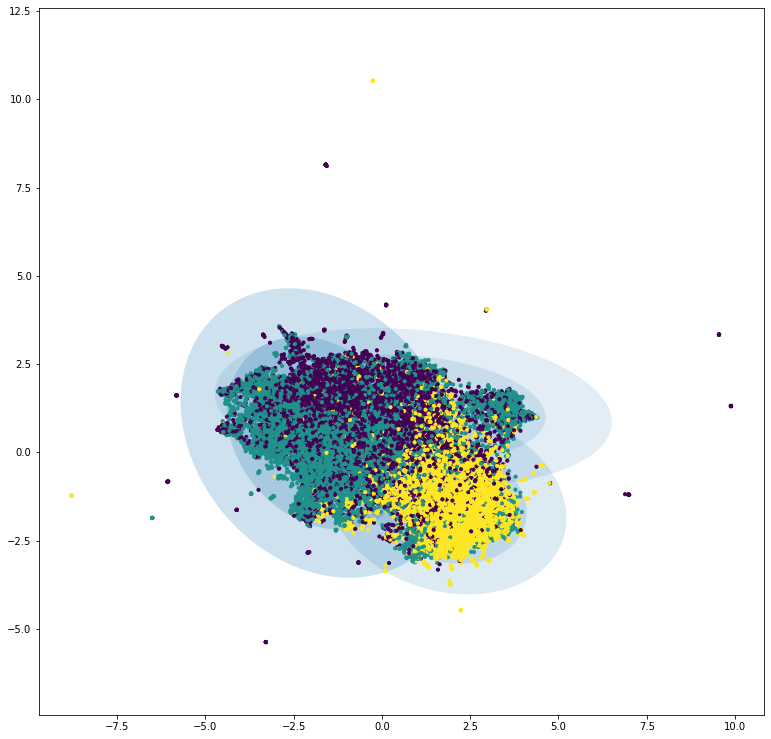

In [13]:
plt.figure(figsize=(13,13))
plot_gmm(gmm, mapper.embedding_, labels=labels)

In [14]:
imgs = pd.Series(sample[0]).map(lambda path: f"http://localhost:8080/{path[11:]}")

In [15]:
TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="224" alt="@imgs" width="224"
            ></img>
        </div>
        <div>@calories</div>
        <div>@probas</div>
    </div>
"""

In [16]:
total_calories = np.expm1(sample[2]).numpy()

In [17]:
probas = gmm.score_samples(X)

In [27]:
colors = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.hot(mpl.colors.Normalize()(total_calories))
]

In [28]:
source = ColumnDataSource(data=dict(
    x=mapper.embedding_[:,0],
    y=mapper.embedding_[:,1],
    imgs=imgs,
    colors=colors,
    calories=total_calories,
    probas=probas
))

In [169]:
p = figure(plot_width=800, plot_height=800, tooltips=TOOLTIPS)
p.scatter('x', 'y', size=4, fill_color="colors", line_color=None, fill_alpha=0.5, source=source)
show(p)

## Analyze GMM

In [167]:
def plot_images(ids, paths, max_num=20, figsize=(15,15)):
    # read images
    ids = ids[:max_num]
    images = []
    for image_id in ids:
        with Image.open(paths[image_id]) as f:
            image = f.convert("RGB")
            images.append(image)

    # plot
    length = np.ceil(len(images) / 4)
    f, axarr = plt.subplots(int(length), 4, figsize=figsize)
    for i, img in enumerate(images):
        x, y = int(np.floor(i / 4)), i % 4
        axarr[x, y].imshow(img)
        axarr[x, y].axis('off')

In [158]:
test_sample = next(iter(dataloader_train))

In [159]:
X_test = test_sample[1]

In [160]:
image_paths = test_sample[0]

In [161]:
test_scores = gmm.score_samples(X_test)

In [162]:
boundary = np.quantile(gmm.score_samples(X), 0.001)
edging_img_ids = np.where(test_scores < boundary)[0]

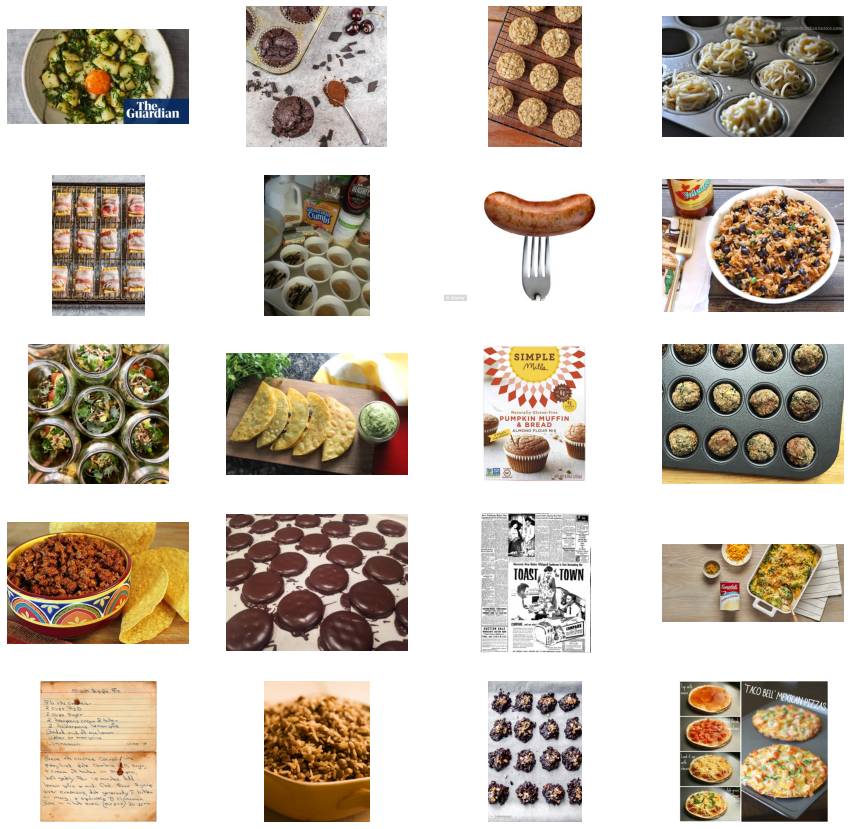

In [168]:
plot_images(edging_img_ids, image_paths)